# Analysis of PBMC10k multiome with ScanPy

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scrublet as scr
import matplotlib.pyplot as plt
from scipy import sparse
import loompy as lp
from loomxpy._loomx import LoomX

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [3]:
results_file = 'output/pbmc10k_multi.h5ad'

In [ ]:
#!wget -P ../data https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.h5 

In [4]:
adata = sc.read_10x_h5('data/pbmc_unsorted_10k_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading data/pbmc_unsorted_10k_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata

AnnData object with n_obs × n_vars = 12012 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Pre-processing

### Filtering by count depth & number of genes per barcode

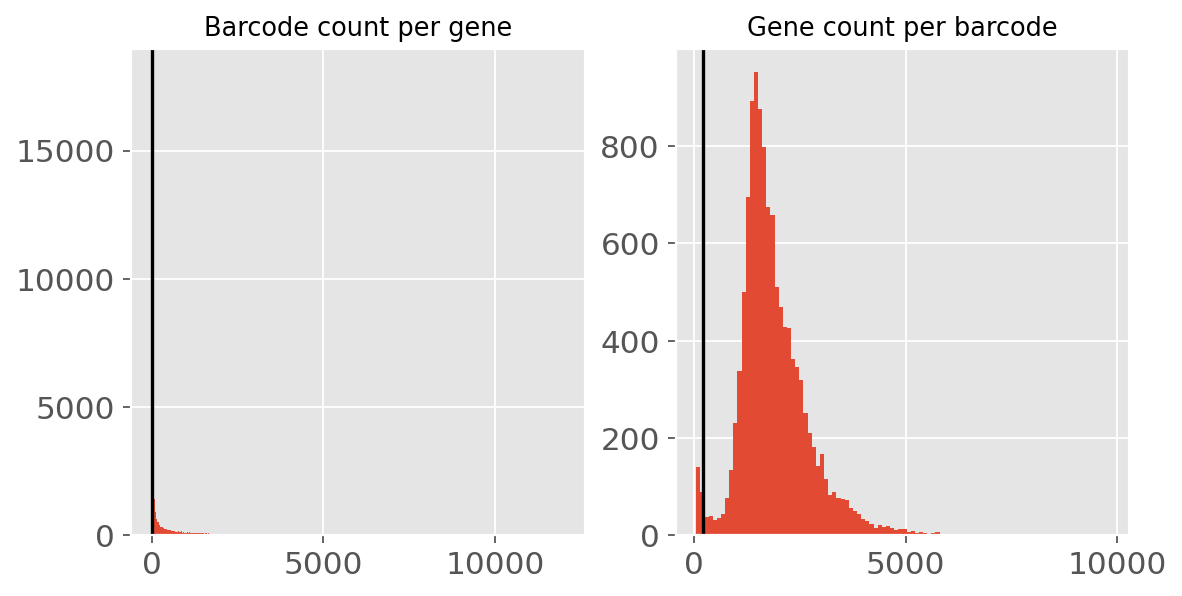

In [6]:
adata_qc = sc.pp.calculate_qc_metrics(adata)

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["font.size"] = 8
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(adata_qc[1]['n_cells_by_counts'],bins='auto')
ax1.axvline(x=3, color='black', linestyle='-')
ax1.set_title("Barcode count per gene")

ax2.hist(adata_qc[0]['n_genes_by_counts'], bins=100)
ax2.axvline(x=200, color='black', linestyle='-')
ax2.set_title("Gene count per barcode")

plt.show()
plt.close()

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 202 cells that have less than 200 genes expressed
filtered out 9526 genes that are detected in less than 3 cells


### Filter by fraction of mitochondrial genes per barcode & no. of genes per barcode

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'feature_types' as categorical
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'genome' as categorical


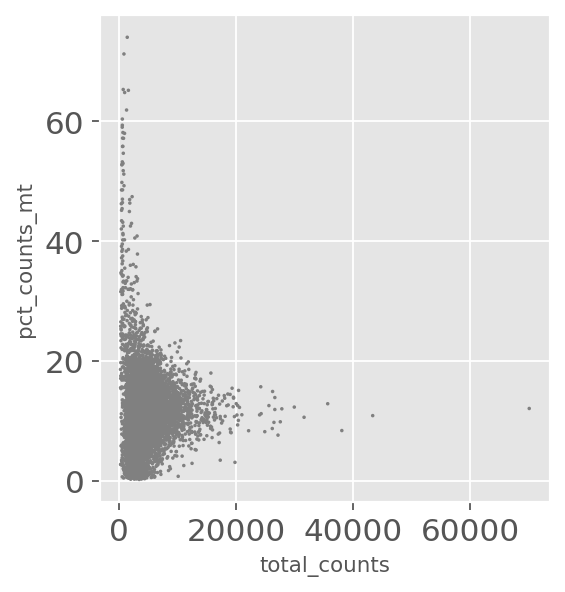

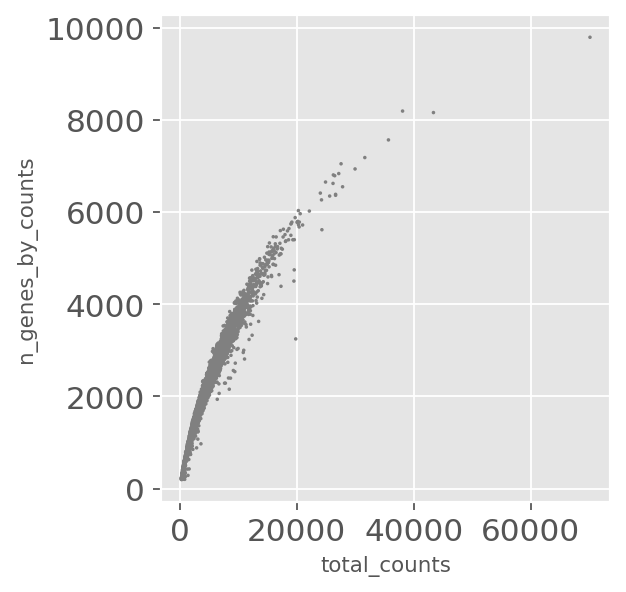

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.pct_counts_mt < 30, :]

### Count normalization

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


Revieved a view of an AnnData. Making a copy.


    finished (0:00:00)


In [12]:
sc.pp.log1p(adata)

### Identify highly variable genes & gene normalization

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


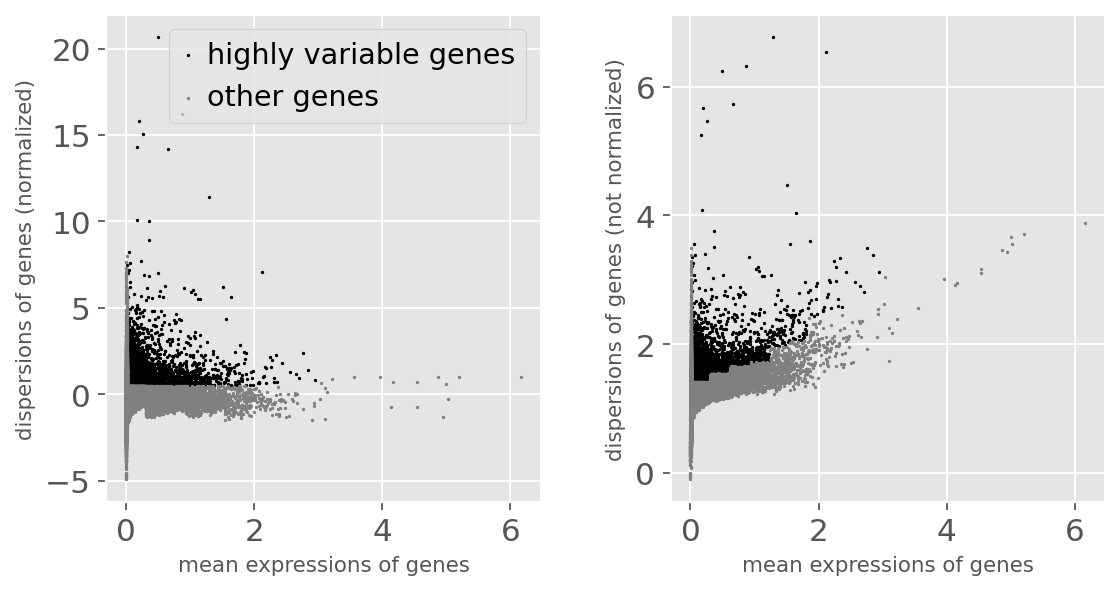

In [14]:
sc.pl.highly_variable_genes(adata)

In [15]:
adata.raw = adata

In [16]:
adata = adata[:, adata.var.highly_variable]

In [17]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:39)


In [18]:
sc.pp.scale(adata, max_value=10)

## Dimensionality Reduction (PCA)

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


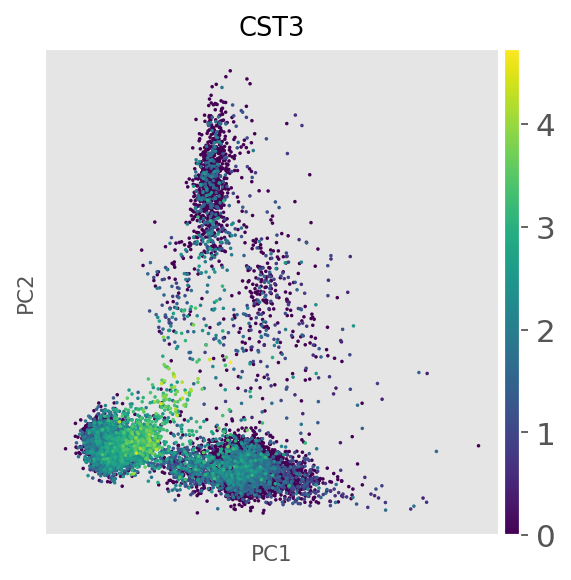

In [20]:
sc.pl.pca(adata, color='CST3')

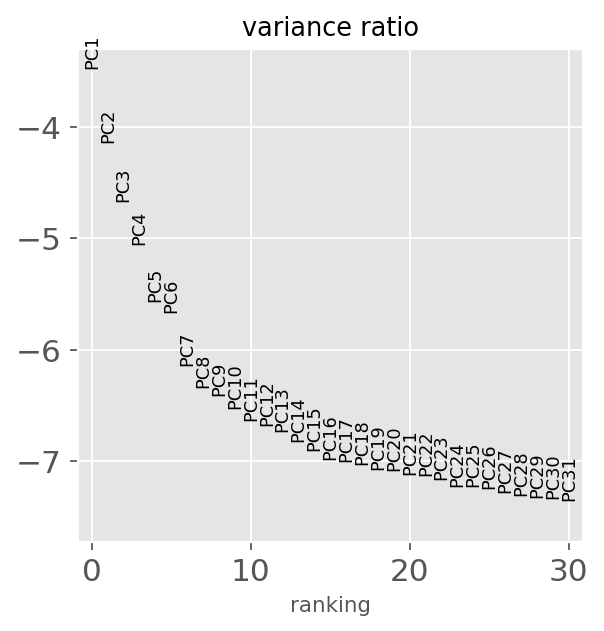

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
adata.write(results_file)

## Constructing & Embedding the neighbourhood graph (UMAP)

In [23]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


In [24]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


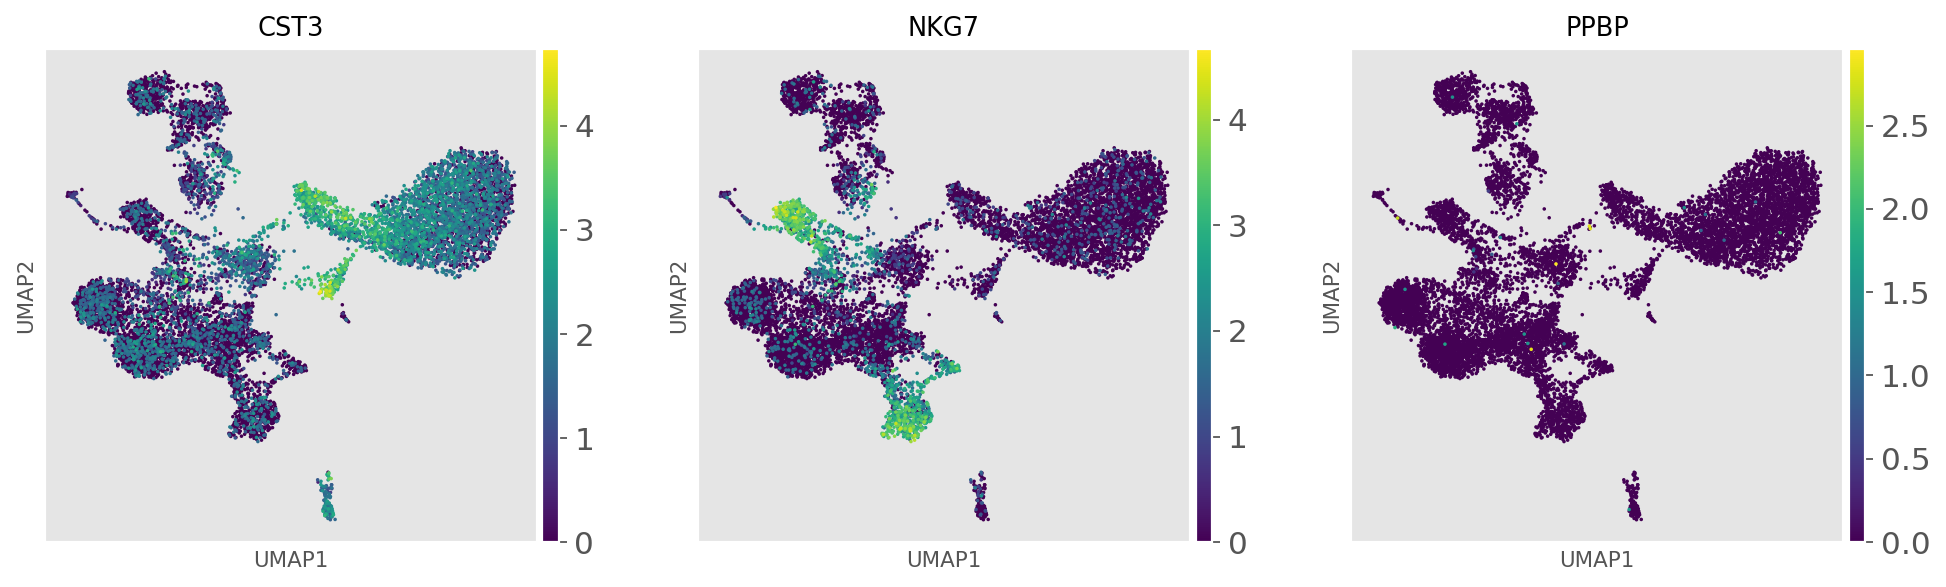

In [25]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

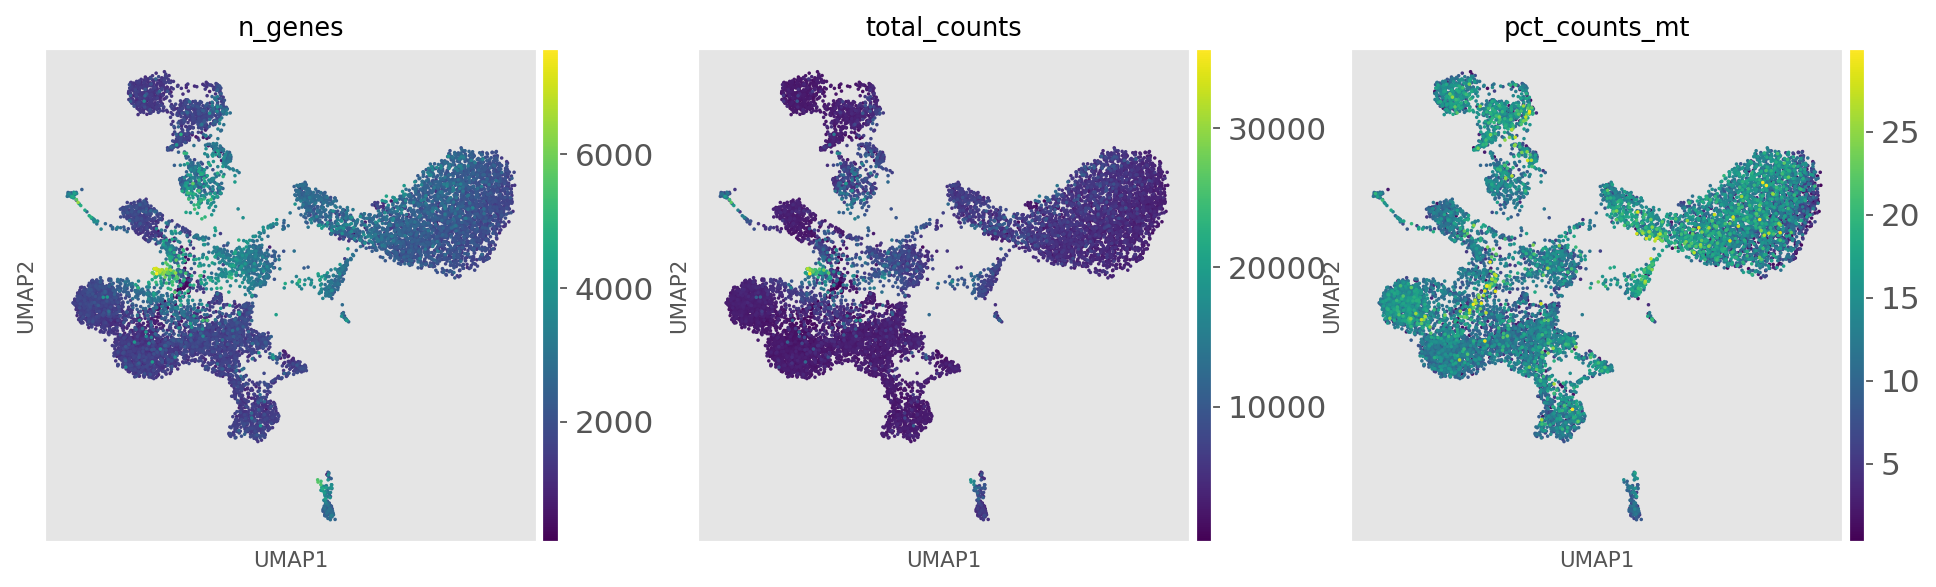

In [26]:
sc.pl.umap(adata, color=['n_genes','total_counts','pct_counts_mt'])

## Clustering

In [27]:
for i in np.arange(0.1,0.5,0.1):
    sc.tl.leiden(adata, resolution=i, key_added="leiden_"+str(i)[:3])

running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.2', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:01)


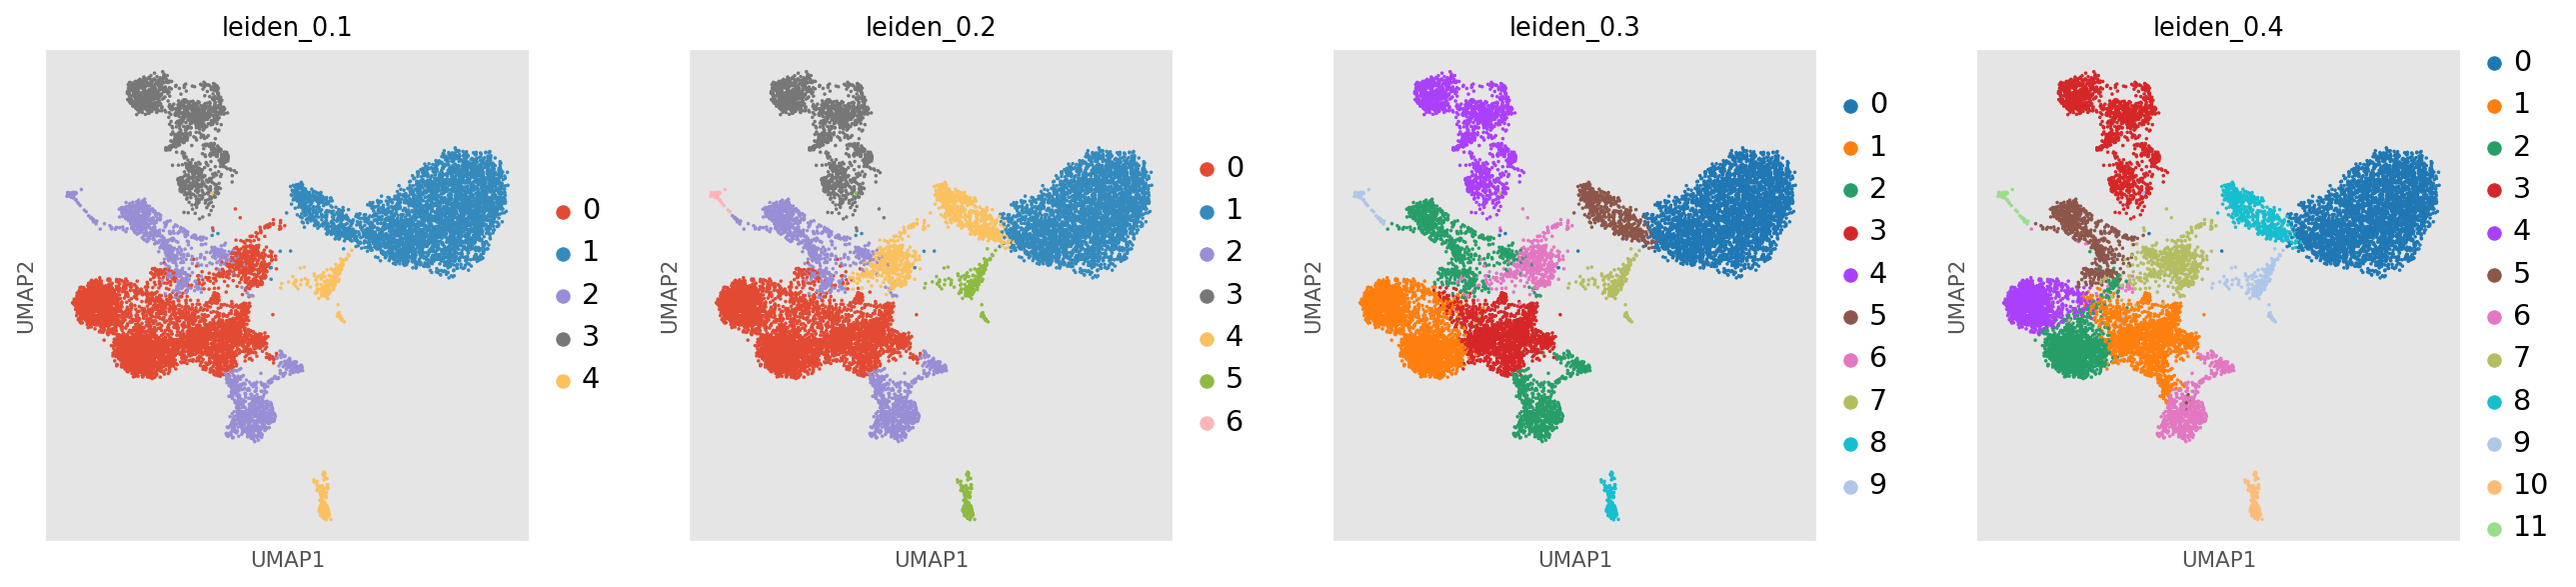

In [28]:
sc.pl.umap(adata, color=['leiden_' + str(i)[:3] for i in np.arange(0.1,0.5,0.1)])

In [29]:
adata.write(results_file)

In [18]:
lx = LoomX()
lx.modes.rna = (adata.raw.X, adata.raw.var.index, adata.obs.index)
#lx.modes.rna.o.embeddings.pca = pd.DataFrame(adata.obsm["X_pca"], index=adata.obs.index)
lx.modes.rna.o.embeddings.umap = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res1 = pd.DataFrame(adata.obs["leiden_0.1"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res2 = pd.DataFrame(adata.obs["leiden_0.2"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res3 = pd.DataFrame(adata.obs["leiden_0.3"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res4 = pd.DataFrame(adata.obs["leiden_0.4"], index=adata.obs.index)
lx.modes.rna.export(filename="./output/pdbc10k_multiome.loom", output_format="scope_v1")

INFO: Adding new rna mode
INFO: LoomX successfully exported to SCope-compatible loom file.


## Find marker genes

From pbmc3k tutorial:

Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)


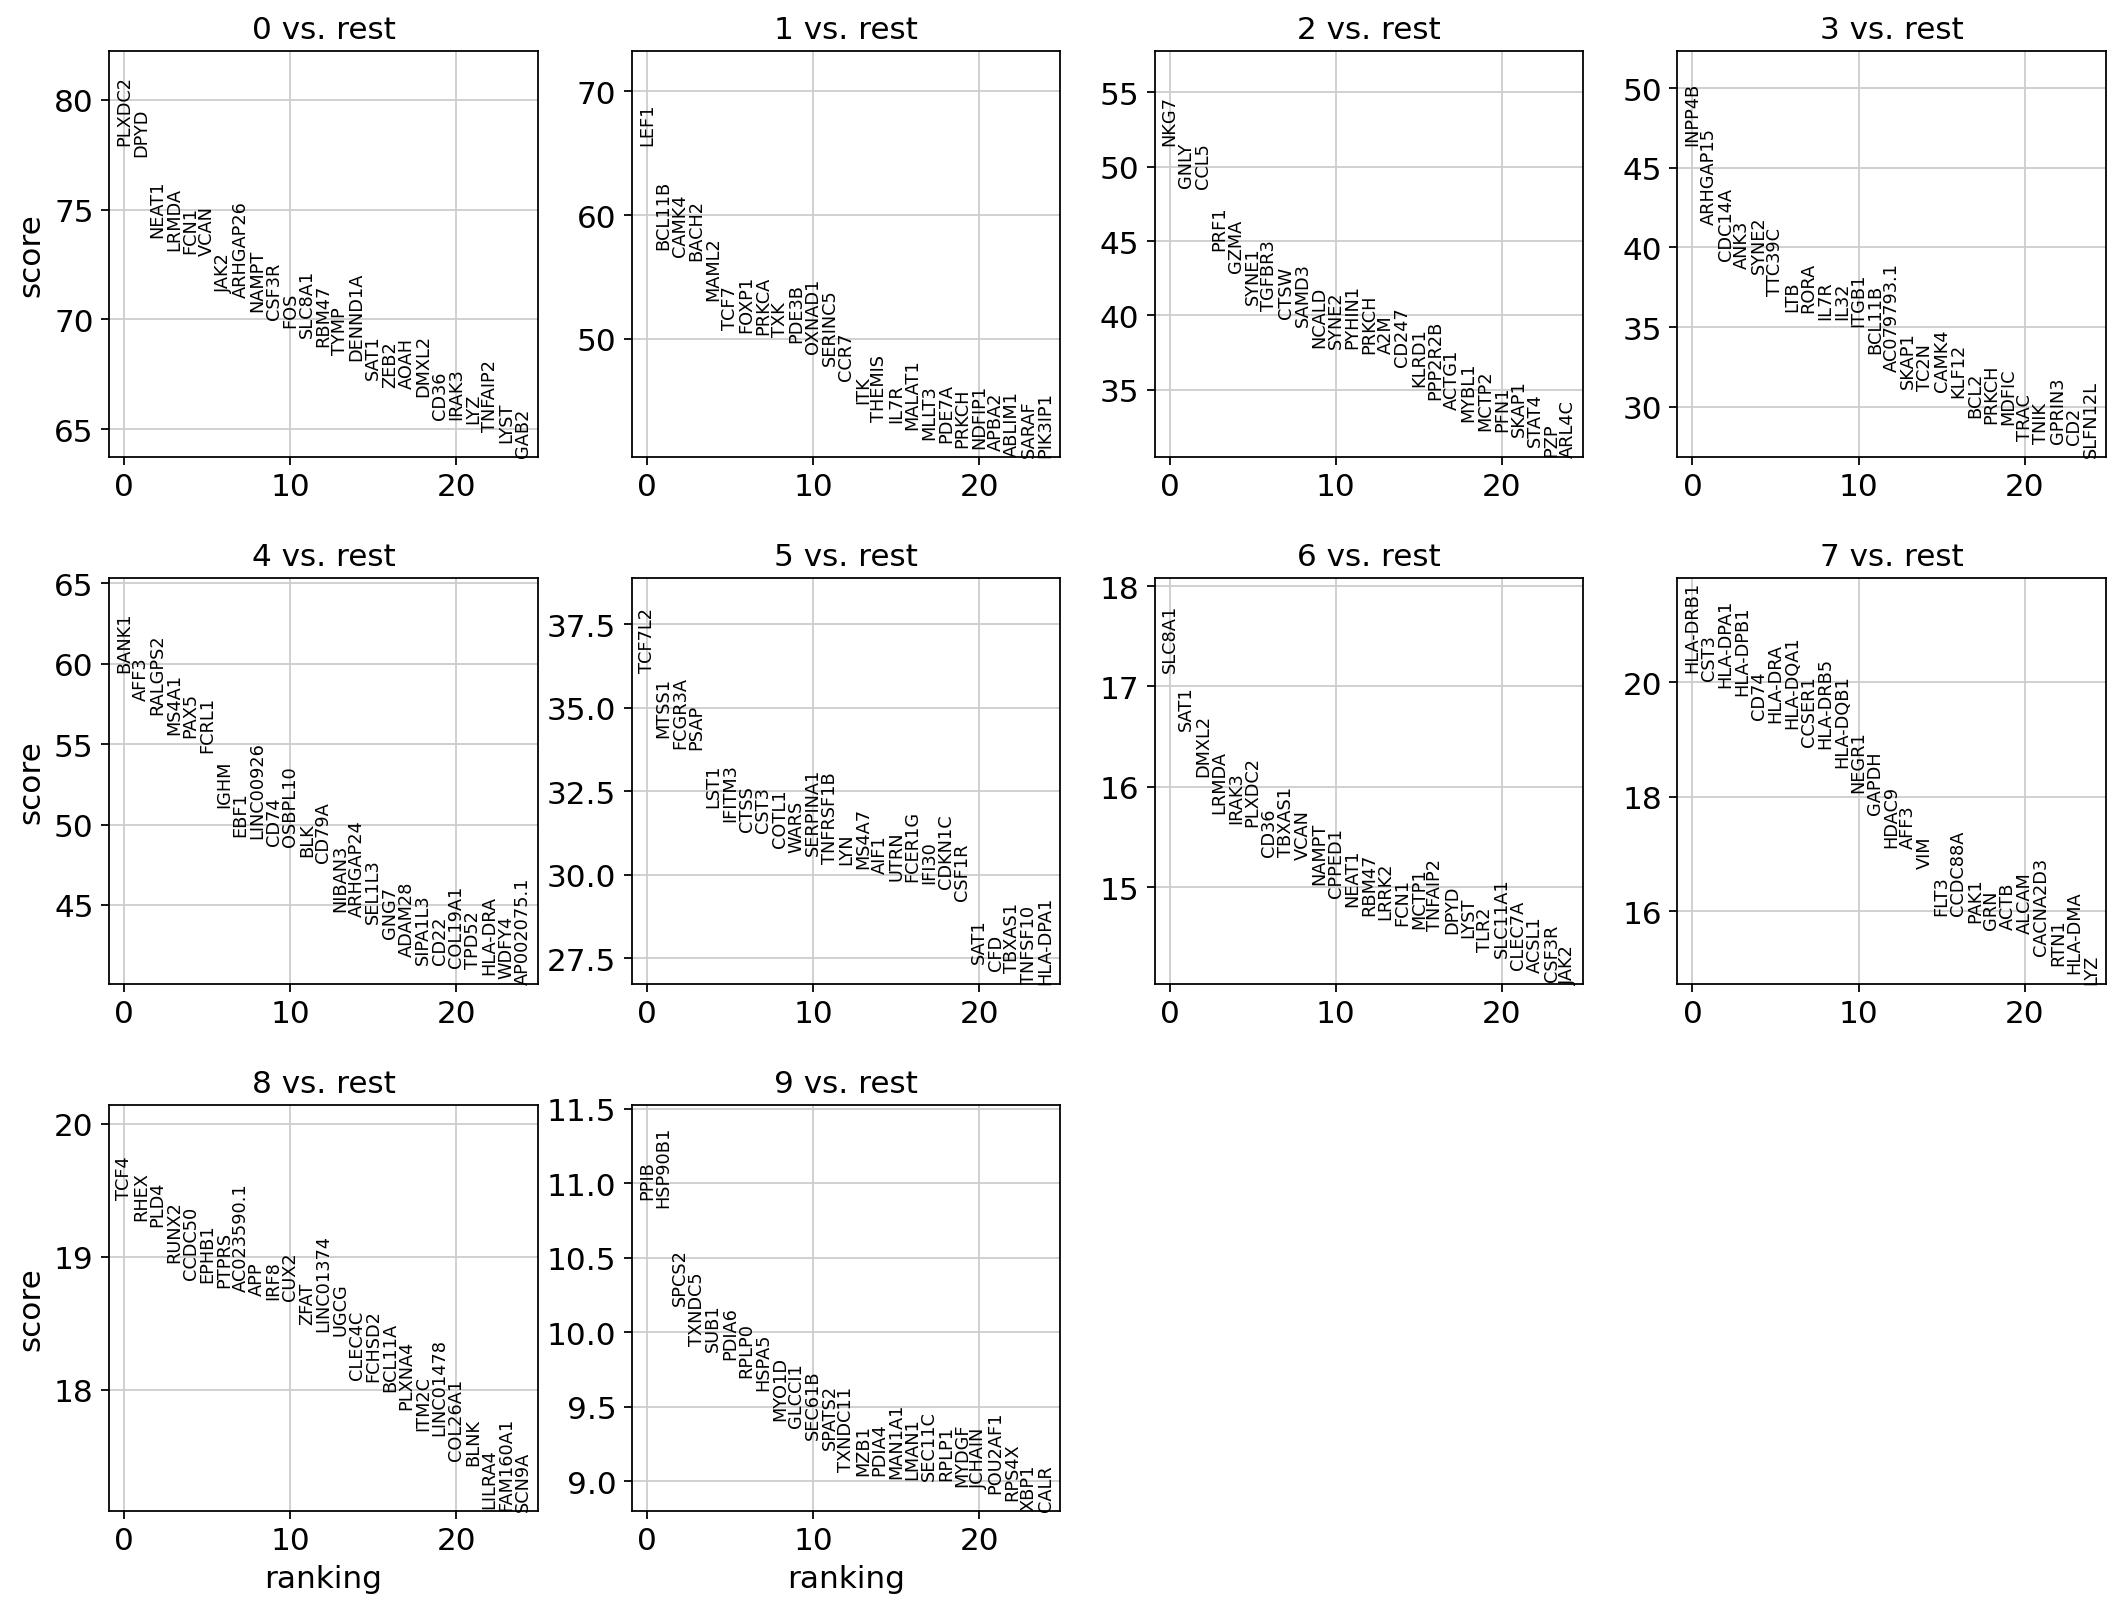

In [20]:
sc.tl.rank_genes_groups(adata, 'leiden_0.3', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [21]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9
0,PLXDC2,LEF1,NKG7,INPP4B,BANK1,TCF7L2,SLC8A1,HLA-DRB1,TCF4,PPIB
1,DPYD,BCL11B,GNLY,ARHGAP15,AFF3,MTSS1,SAT1,CST3,RHEX,HSP90B1
2,NEAT1,CAMK4,CCL5,CDC14A,RALGPS2,FCGR3A,DMXL2,HLA-DPA1,PLD4,SPCS2
3,LRMDA,BACH2,PRF1,ANK3,MS4A1,PSAP,LRMDA,HLA-DPB1,RUNX2,TXNDC5
4,FCN1,MAML2,GZMA,SYNE2,PAX5,LST1,IRAK3,CD74,CCDC50,SUB1


In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
sc.pl.umap(adata, color=marker_genes)

In [32]:
marker_genes_dict = {
    'CD4 T Cells': ['IL7R'],
    'CD14+ Monocytes': ['CD14', 'LYZ'],
    'CD8 T Cells': ['CD8A'],
    'NK Cells': ['GNLY', 'NKG7'],
    'B-cell': ['CD79A', 'MS4A1'],
    'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'Megakaryocytes': ['PPBP'],
    'Other': ['IGLL1']
}

categories: 0, 1, 2, etc.
var_group_labels: CD4 T Cells, CD14+ Monocytes, CD8 T Cells, etc.


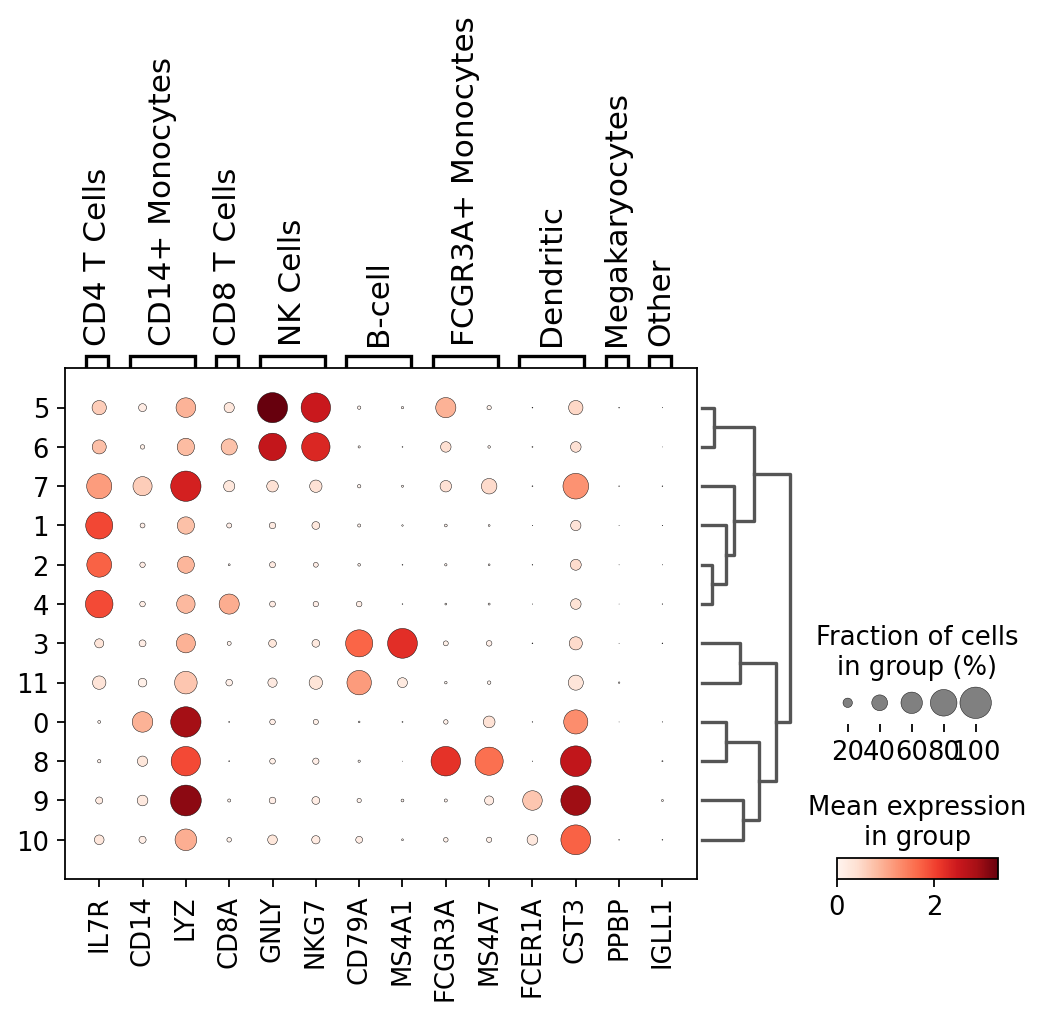

In [33]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden_0.4', dendrogram=True)

In [34]:
cluster2annotation = {
     '0': 'CD14+ Monocytes',
     '1': 'CD4 T Cells',
     '2': 'CD4 T Cells',
     '3': 'B Cells',
     '4': 'CD4 T Cells',
     '5': 'NK Cells',
     '6': 'NK Cells',
     '7': 'CD14+ Monocytes',
     '8': 'FCGR3A+ Monocytes',
     '9': 'Dendritic Cells',
     '10': 'Dendritic Cells',
     '11': 'B Cells'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['leiden_0.4'].map(cluster2annotation).astype('category')

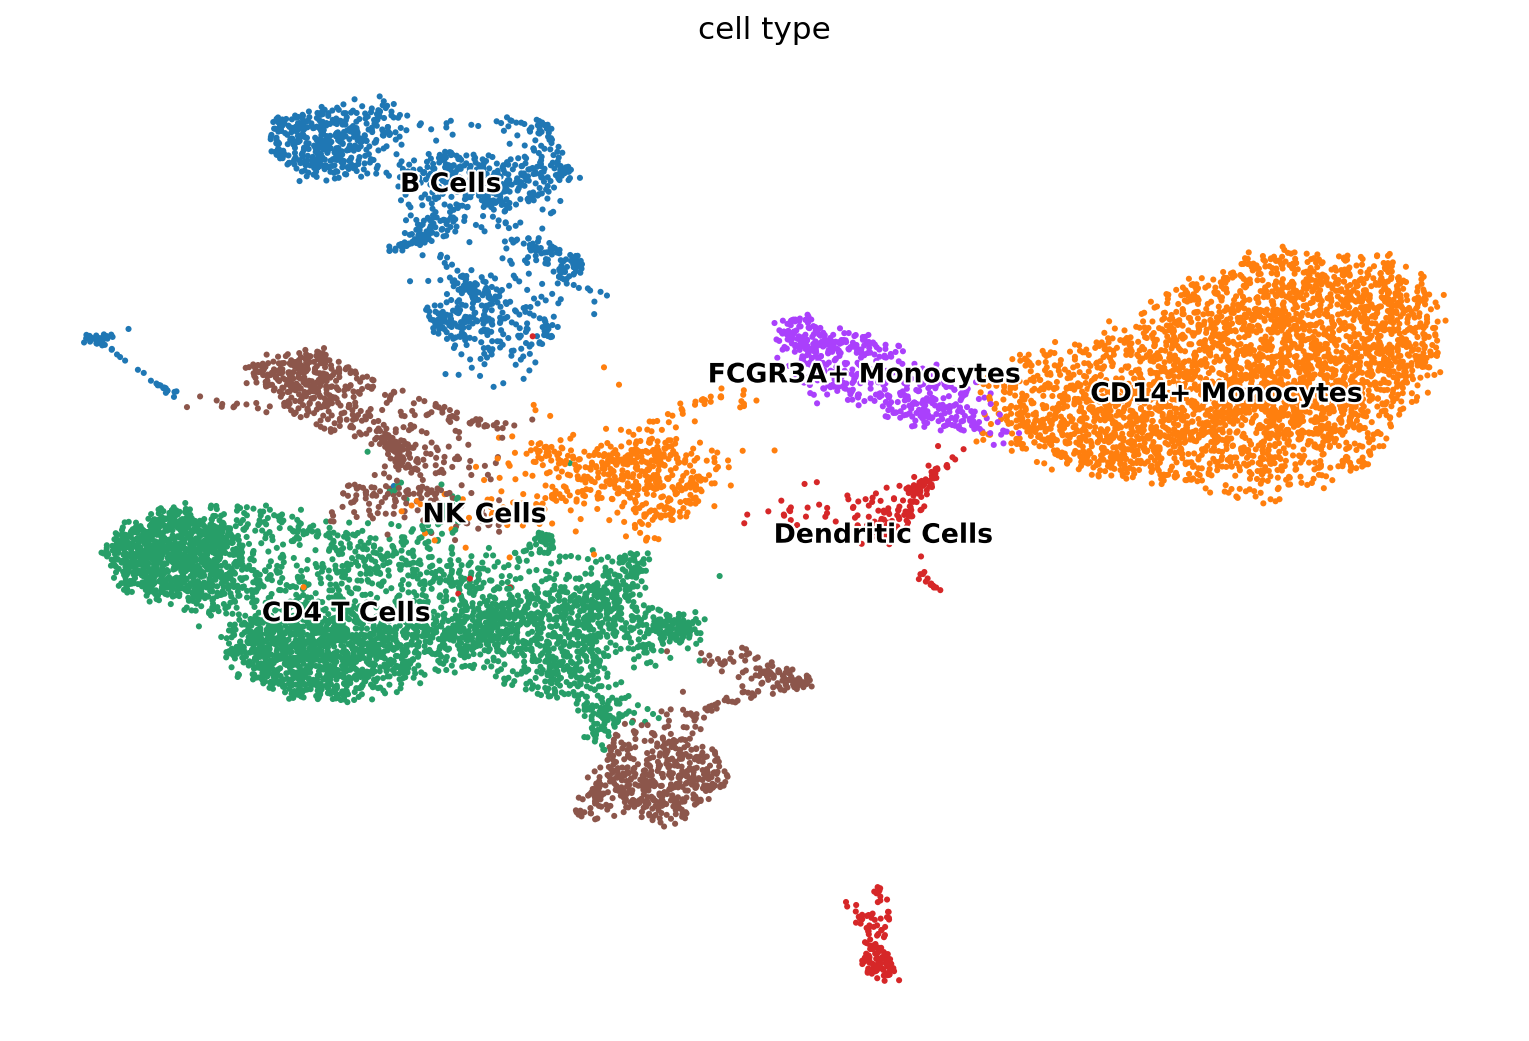

In [51]:
plt.rcParams["figure.figsize"]=(12,8)
sc.pl.umap(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=12, size=30, legend_fontoutline=2)

categories: 0, 1, 2, etc.
var_group_labels: CD4 T Cells, CD14+ Monocytes, CD8 T Cells, etc.


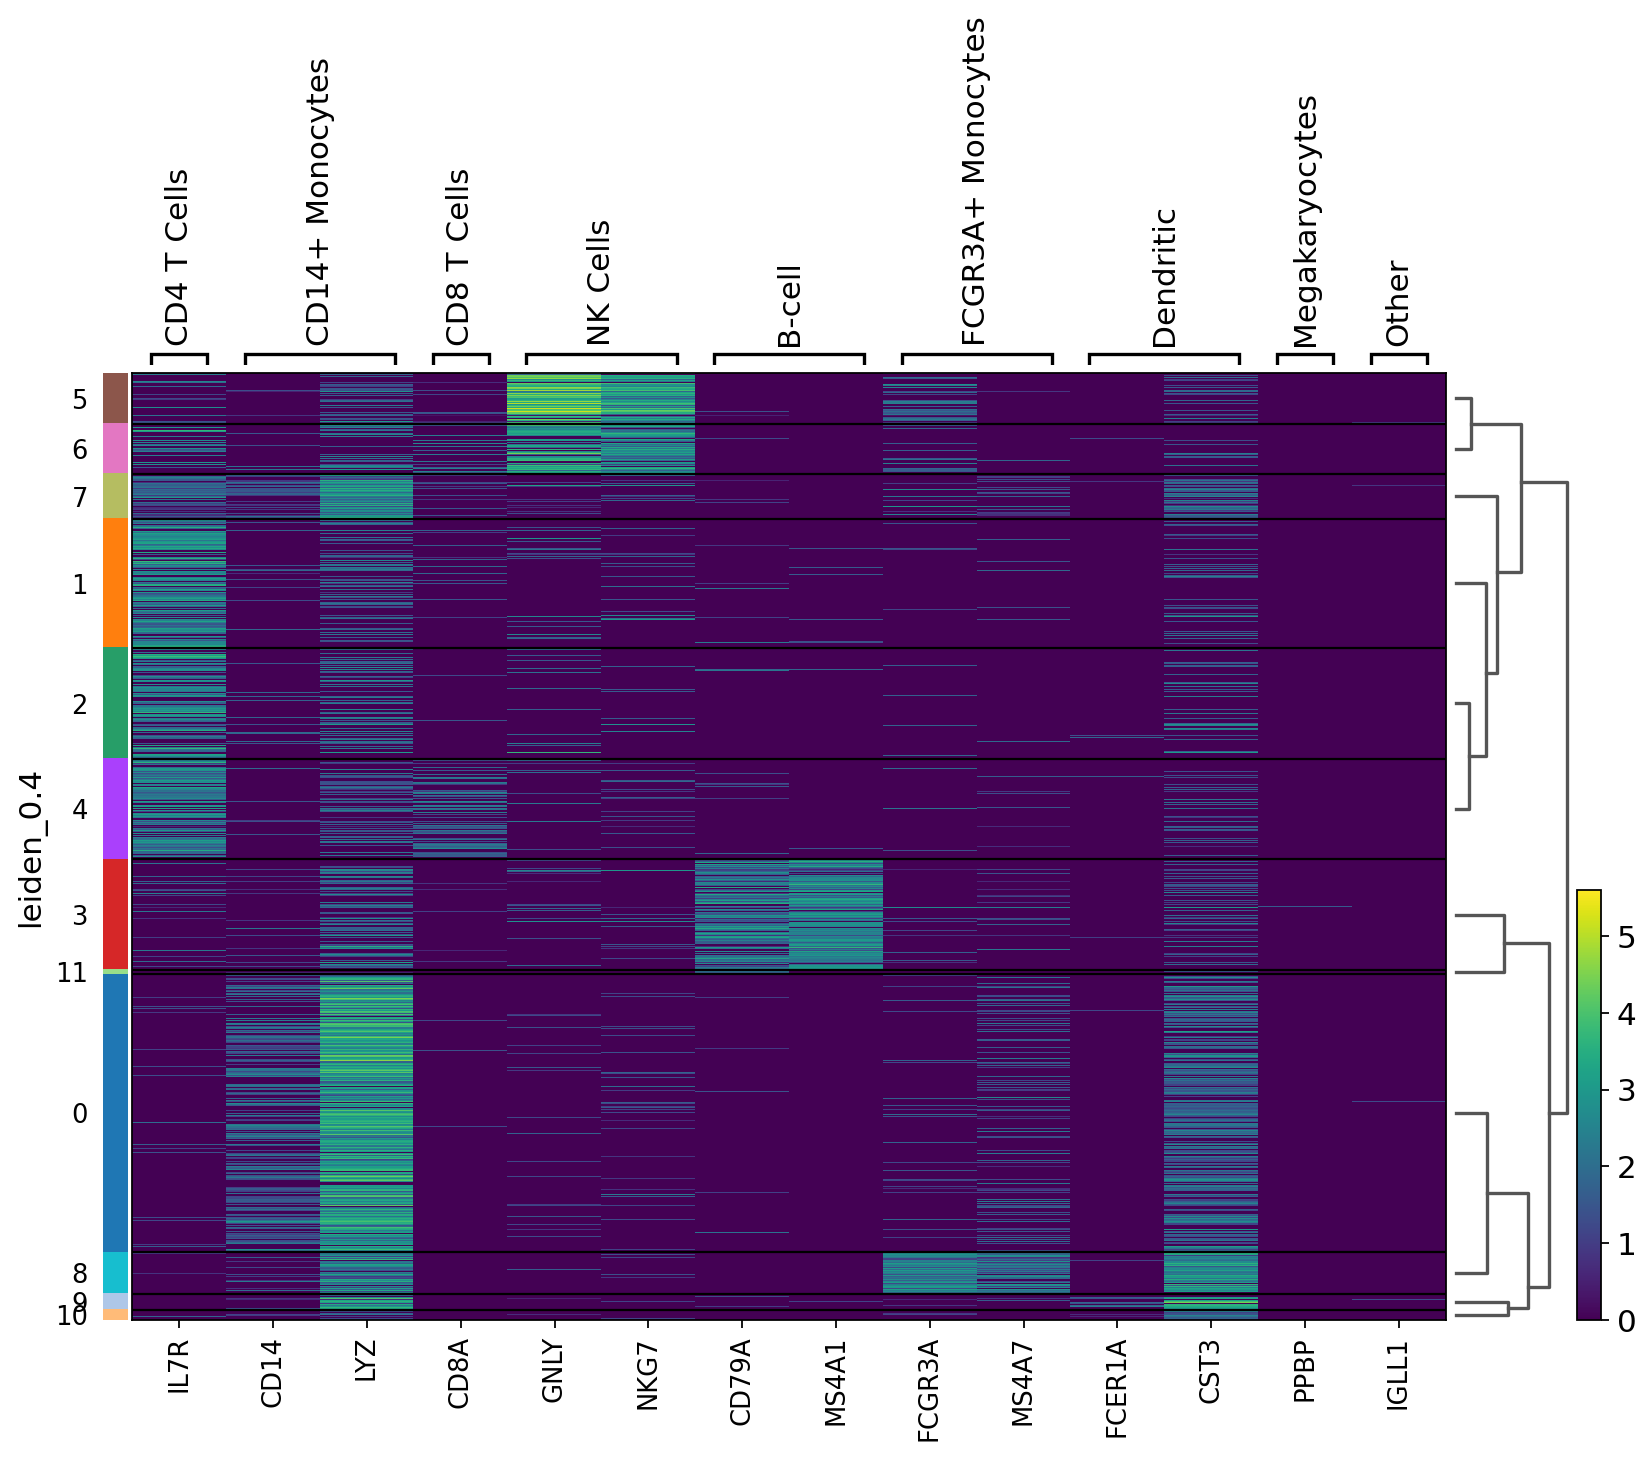

In [43]:
sc.pl.heatmap(adata, marker_genes_dict, groupby='leiden_0.4', cmap='viridis', dendrogram=True, figsize=(12,8))

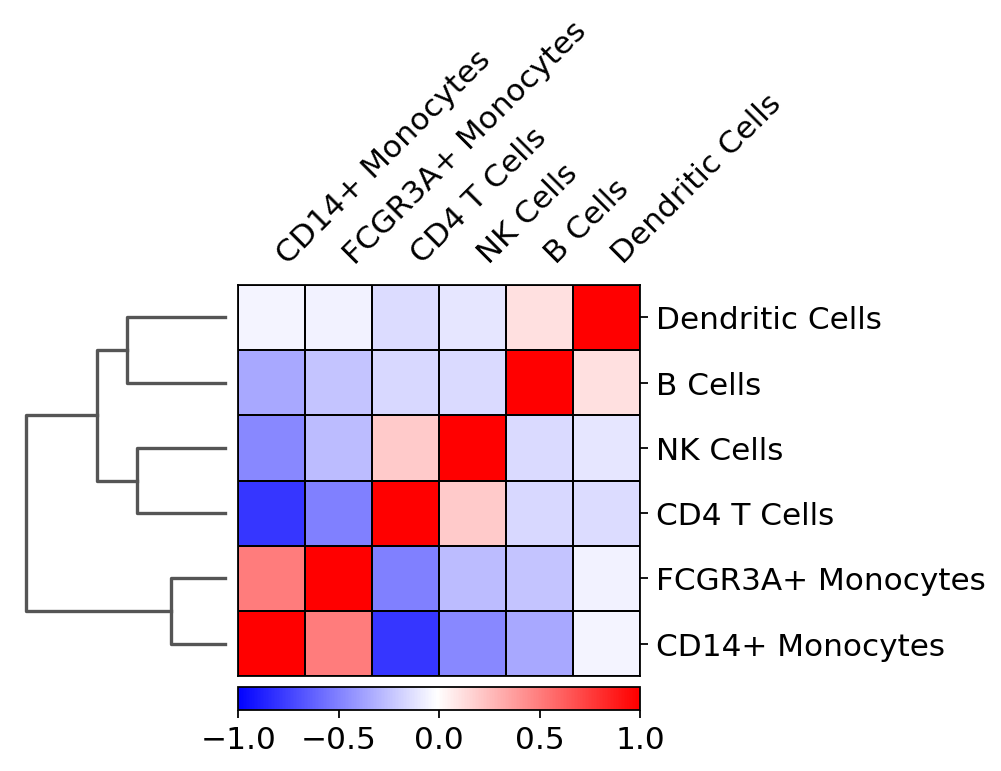

In [46]:
sc.pl.correlation_matrix(adata, 'cell type', figsize=(5,3.5))

## Remarks
- By inspecting the marker genes provided by the PBMC3K tutorials, some clusters defined on the UMAP embeddings seem to belong to more than one cell type. This indicates the possibility of doublets.